# IBS simulations based on Nick's mathematica file

## Main description

There are main varibales 
nLoci - number of loci;  
nT- number of traits; 
nInds - number of individuals;
beta - [0.1, 0.2]

<b>Genotype,</b> labelled 'pop', has shape nInd x nLoci, contains only 0 and 1. <b> Each locus influences each trait?! </b>


Then there are <b>weights</b> -  drawn from exponential distribution (var =1), multiplied by normal distribution (mean 0, var 1) to make it negative half of the time, divided by sqrt nLoci.  Something like this was in Nick's mathematica file. Resulting distribtion has <b>variance 2</b>! This is matrix nT x nLoci. Does this mean that each locus influences each trait, with different weight? How is the trait value determined? As sum across genotype x weights? 

<b>Single generation</b> In each generation, individuals mutate, then their fitness is calculated, and new individuals are generated by sampling with replacement from the old population, probabilities given by their fitness. See below. 

<b>Mutation</b> means flipping a bit. Each bit can be flipped with probability p, given as 1/(nLoci*nInds) - in this case mutations are too weak. <b>What should it be?</b> Using 0.001 sometimes  

<b>Fitness</b>  of each individual is calculated as exp (trait 1 x beta 1) + exp (trait 2 x beta 2). Is this correct? My fitness values are higher that in Nick's mathematica file. 

<b>Selection</b> here is based on selecting indviduals proportianally to normalized fitness (individual's fitness /total fitness)




In [1]:
import numpy as np   
import matplotlib.pyplot as plt    
%matplotlib inline

## Definitions

In [2]:
def calcFitness (pop, weights, beta):
    T1 = np.matmul(pop,weights[:,0])  #this is not general, only for particular traits
    T2 = np.matmul(pop, weights[:,1])
    
    fitness =np.exp(T1*beta[0])+np.exp(T2*beta[1])
    #print (fitness)
    return fitness


def selection(pop, weights, beta):
    #multiply matrix of individual x loci by weights to get fitness for each individual -> maybe more complex 
    #sample these individual proportiannly to their fitness
    fitness = calcFitness(pop, weights, beta)
    (nI,nL) = pop.shape
    chosen = np.random.choice(np.arange(nI),nI, p=fitness/sum(fitness))   #so fitness of all individuals adds to one 
    
    chosen = np.sort(chosen)
    newPop = pop[chosen,:]
    return newPop

def mutate(pop, p): #each locus in each individual can flip with probability p  
    (nI,nL) = pop.shape
    count=0
    for i in range(nI):
        for j in range(nL):
            if p>np.random.sample(1):
                pop[i,j]=pop[i,j]*(-1)+1   #fliping the bit
                count=count +1
    return pop
            
 

In [5]:
def singleEvoTrial(oldPop, weights, beta,mutProb, gen):
    #Simulate single evolutionary trial. Collects sum of fitness across population, variance, and evolved genotype
    sumF = []
    sumF.append(np.sum(calcFitness(oldPop, weights, beta)))
    varF = []
    varF.append(np.var(calcFitness(oldPop, weights, beta)))
    evolGen = []
    evolGen.append(oldPop.flatten())  
    #this captures the whole population, nInds x nLoci - remove if you want large numbers! 
    alleleFreq = []
    alleleFreq.append(np.mean(oldPop,0))
    

    for i in range(gen):
        pop=mutate(oldPop.copy(), mutProb)
        newPop = selection(pop.copy(), weights.copy(), beta)
        oldPop = newPop;
        
        evolGen.append(oldPop.flatten())
        sumF.append(np.sum(calcFitness(oldPop, weights, beta)))
        varF.append(np.var(calcFitness(oldPop, weights, beta)))
        alleleFreq.append(np.mean(oldPop,0))
    
    sumF = np.array(sumF)
    varF = np.array(varF)
    alleleFreq=np.array(alleleFreq)
    
    evolGen = np.array(evolGen)
    return (newPop, sumF, varF, evolGen, alleleFreq)

def calculateTraitValues(pop,weights):
    trait1 = np.matmul(pop, weights[:,0])  
    trait2 = np.matmul(pop, weights[:,1])
    return trait1, trait2

        

In [8]:
def mainRun2Traits():
    nLoci = 500  # number of loci per trait
    nT = 2   #number of traits
    nInds = 100   #number of individuals
    
    beta = [0.1,0.2]  #strength of selection on each trait
    gen = 400
    mutProb = 0.001#10.0/(nLoci*nInds)  #mutation per locus, this should result in 10 mut per gen
    
    #weights = np.random.sample(nLoci*nT)/np.sqrt(nLoci)  # these weights are drawn from uniform 
    #distribution between 0-1
    

    weights = 1/np.sqrt(nLoci)*np.random.exponential(1, [ nLoci, nT])*np.random.normal(0,1,[ nLoci, nT])  
    #exponential distribution in random direction? 
    
    
    pop0 = np.random.randint(0,2,(nInds, nLoci))  #generate new population
    [lastPop, fit,var, evolGen, alleleFreq] = singleEvoTrial(pop0.copy(), weights.copy(), beta, mutProb,gen)
    
    plt.plot(fit)
    plt.xlabel('time')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(var)
    plt.xlabel('time')
    plt.ylabel('variance in fitness')
    plt.show()
    
    #plt.pcolor(np.transpose(evolGen))  #this is too slow for nLoci =1000 and nInds = 100
    #plt.xlabel('time')
    #plt.ylabel('loci')
    #plt.show()

    #print ('Allele frequencies 0', alleleFreq[1,:])
    #print ('Allele frequencies 1', alleleFreq[-1,:])
    
    plt.scatter(alleleFreq[1,:],alleleFreq[-1,:])
    plt.xlabel('allele frequency at the beginning')
    plt.ylabel('allele frequency at the end')
    lastOne = evolGen[-1,:]
    lastOne = np.reshape(lastOne, (nInds, nLoci))
    unique = np.unique(lastOne,axis=0)
    print ('no of unique:', unique.shape[0])
    print ('unique types:', unique)
    return lastPop, fit,var, evolGen, alleleFreq, pop0,  weights, beta

# Example 1: 2 traits

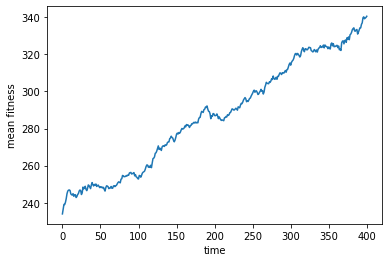

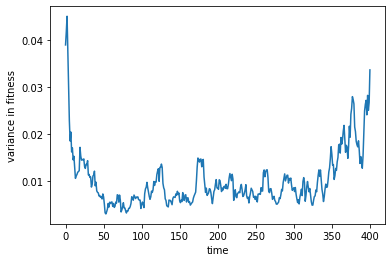

no of unique: 55
unique types: [[0 1 1 ... 0 1 0]
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


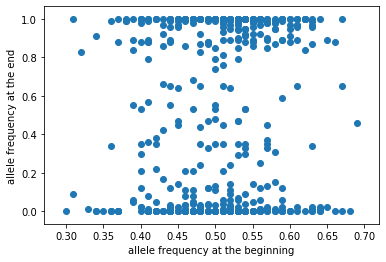

In [9]:
[lastPop, fit,var, evolGen, alleleFreq, pop0, weights, beta] = mainRun2Traits()

The plots above show 1) increase in mean fitness; 2) decrease in variance and 3) allele frequence at the end vs at the beginning. it shows that many of the alleles get fixed, or are lost

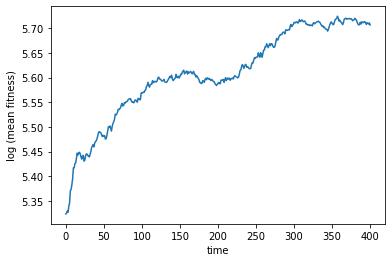

In [185]:
plt.plot(np.log(fit))
plt.xlabel('time')
plt.ylabel('log (mean fitness)')
plt.show()


ok, this values are about twice as large as Nick's, because of the different weights distribution? 

In [186]:
#plt.pcolor(np.transpose(evolGen))  #this should show all genotypes in time but it is too slow for nLoci =500 and nInds = 100
#plt.xlabel('time')
#plt.ylabel('loci')
#plt.show()

## Plotting trait values

In [199]:

numGen=(evolGen.shape[0])
nLoci=(pop0.shape[1])
nInds=pop0.shape[0]

print ('generations:', numGen, 'Loci:', nLoci, 'Individuals:', nInds)


generations: 401 Loci: 500 Individuals: 100


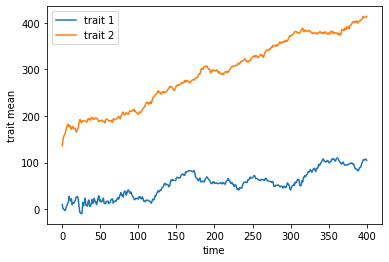

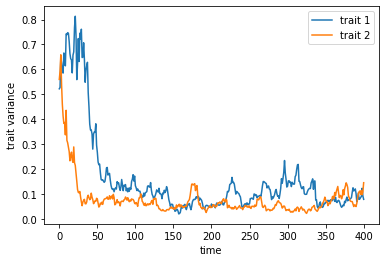

In [17]:

allPhen = []
for i in range (numGen):    
    pop = evolGen[i,:]
    pop=np.reshape(pop,[nInds, nLoci])    
    thisPhen = calculateTraitValues(pop,weights)
    allPhen.append(thisPhen)
allPhen = np.array(allPhen)


plt.plot(np.sum(allPhen,2))
plt.xlabel('time')
plt.ylabel('trait mean')
plt.legend(['trait 1','trait 2'])

plt.show()

plt.plot(np.var(allPhen,2))
plt.xlabel('time')
plt.ylabel('trait variance')
plt.title=('decreasing variance')
plt.legend(['trait 1','trait 2'])
plt.show()




The figures above show that the values of both traits are increasing, variance is decreasing. 

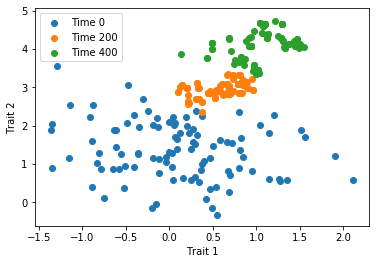

In [18]:
plt.scatter(allPhen[0,0,:],allPhen[0,1,:])
plt.scatter(allPhen[200,0,:],allPhen[200,1,:])
plt.scatter(allPhen[400,0,:],allPhen[400,1,:])
plt.xlabel('Trait 1')
plt.ylabel('Trait 2')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()



means of both traits are increasing, variance decreasing, snapshots in 3 times. 

In Nick's simulation the effect is stronger - probably because the fitness calculation is different? and the weights are from a different distribution

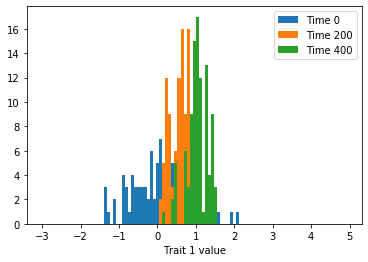

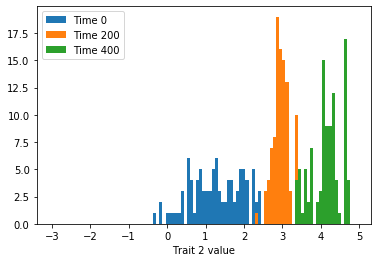

In [19]:
myBins=np.arange(-3,5,0.08)

plt.hist(allPhen[0,0,:],bins=myBins)
plt.hist(allPhen[200,0,:],bins=myBins)
plt.hist(allPhen[400,0,:],bins=myBins)

plt.xlabel('Trait 1 value')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()

plt.hist(allPhen[0,1,:], bins=myBins)
plt.hist(allPhen[200,1,:],bins=myBins)
plt.hist(allPhen[400,1,:],bins=myBins)

plt.xlabel('Trait 2 value')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()


Histograms of trait values in 3 different times. 

## Plotting other funny stuff

(500, 2)
(500,)


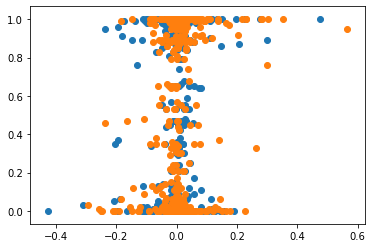

In [20]:
print (np.shape(weights))

lastOne = evolGen[-1,:]
lastOne = np.reshape(lastOne, (nInds, nLoci))
print (np.shape(np.mean(lastOne,0)))
plt.scatter(weights[:,0], np.mean(lastOne,0), marker='o')
plt.scatter(weights[:,1], np.mean(lastOne,0), marker='o')
plt.show()

Here I am plotting the allele frequency at the end as a function of the weight associated with the particular locus, for both traits

Text(0.5, 0, 'Allele frequency')

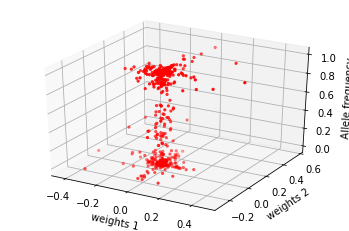

In [21]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights[:,0], weights[:,1], np.mean(lastOne,0), c='r', marker='.')

ax.set_xlabel('weights 1')
ax.set_ylabel('weights 2')
ax.set_zlabel('Allele frequency')

and here I am doing the same thing, but in 3d, as function of both weights, because if in opposite directions, they work against each other

# Example 2: Single trait

is it not the same as stating that beta on the second trait is 0? Then there is no selection on that trait and it is the same as having a single trait scenario? 

In [108]:
def mainRun1Trait():
    nLoci = 500  # number of loci per trait
    nT = 2   #number of traits
    nInds = 100   #number of individuals
    
    beta = [0.1,0.0]  #strength of selection on each trait
    gen = 1000
    mutProb = 0.001#10.0/(nLoci*nInds)  #mutation per locus, this should result in 10 mut per gen
    
    #weights = np.random.sample(nLoci*nT)/np.sqrt(nLoci)  # these weights are drawn from uniform 
    #distribution between 0-1
    

    weights = 1/np.sqrt(nLoci)*np.random.exponential(1, [ nLoci, nT])*np.random.normal(0,1,[ nLoci, nT])  
    #exponential distribution in random direction? 
    
    
    pop0 = np.random.randint(0,2,(nInds, nLoci))  #generate new population
    [lastPop, fit,var, evolGen, alleleFreq] = singleEvoTrial(pop0.copy(), weights.copy(), beta, mutProb,gen)
    
    plt.plot(fit)
    plt.xlabel('time')
    plt.ylabel('mean fitness')
    plt.show()
    
    plt.plot(var)
    plt.xlabel('time')
    plt.ylabel('variance in fitness')
    plt.show()
    
    #plt.pcolor(np.transpose(evolGen))  #this is too slow for nLoci =1000 and nInds = 100
    #plt.xlabel('time')
    #plt.ylabel('loci')
    #plt.show()

    #print ('Allele frequencies 0', alleleFreq[1,:])
    #print ('Allele frequencies 1', alleleFreq[-1,:])
    
    plt.scatter(alleleFreq[1,:],alleleFreq[-1,:])
    plt.xlabel('allele frequency at the beginning')
    plt.ylabel('allele frequency at the end')
    lastOne = evolGen[-1,:]
    lastOne = np.reshape(lastOne, (nInds, nLoci))
    unique = np.unique(lastOne,axis=0)
    print ('no of unique:', unique.shape[0])
    print ('unique types:', unique)
    return lastPop, fit,var, evolGen, alleleFreq, pop0,  weights, beta

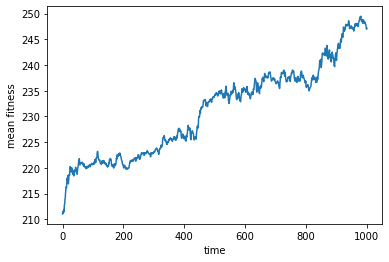

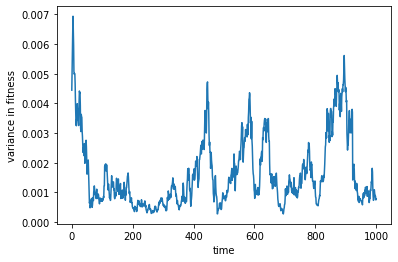

no of unique: 54
unique types: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


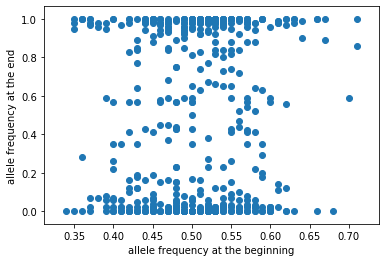

In [109]:
[lastPop1, fit1,var1, evolGen1, alleleFreq1, pop01, weights1, beta1] = mainRun1Trait()

The plots above show 1) increase in mean fitness; 2) decrease in variance and 3) allele frequence at the end vs at the beginning. it shows that many of the alleles get fixed, or are lost

In [110]:
numGen=(evolGen1.shape[0])
nLoci=(pop01.shape[1])
nInds=pop01.shape[0]

print ('generations:', numGen, 'Loci:', nLoci, 'Individuals:', nInds)


generations: 1001 Loci: 500 Individuals: 100


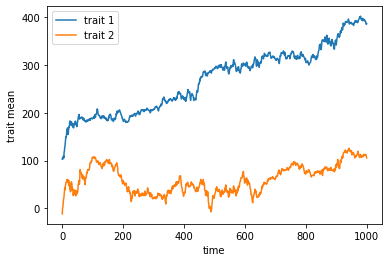

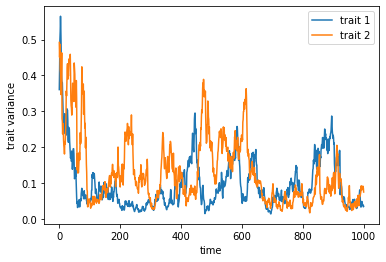

In [111]:
allPhen = []   #note that I have to change variable names here to 1 !!!
for i in range (numGen):    
    pop = evolGen1[i,:]
    pop=np.reshape(pop,[nInds, nLoci])    
    thisPhen = calculateTraitValues(pop,weights1)
    allPhen.append(thisPhen)
allPhen = np.array(allPhen)


plt.plot(np.sum(allPhen,2))
plt.xlabel('time')
plt.ylabel('trait mean')
plt.legend(['trait 1','trait 2'])

plt.show()

plt.plot(np.var(allPhen,2))
plt.xlabel('time')
plt.ylabel('trait variance')
plt.title=('decreasing variance')
plt.legend(['trait 1','trait 2'])
plt.show()

The figures above show that the value of trait 1 is increasing, trait 2 is just dancing around. As it is encoded by the same loci, it is also changing, but not clearly in any particular direction

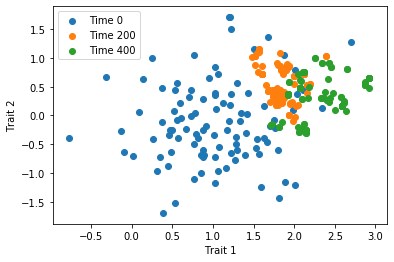

In [112]:
plt.scatter(allPhen[0,0,:],allPhen[0,1,:])
plt.scatter(allPhen[200,0,:],allPhen[200,1,:])
plt.scatter(allPhen[400,0,:],allPhen[400,1,:])
plt.xlabel('Trait 1')
plt.ylabel('Trait 2')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()


same as above. Deacrease in variance in both traits, as we have the same loci. 


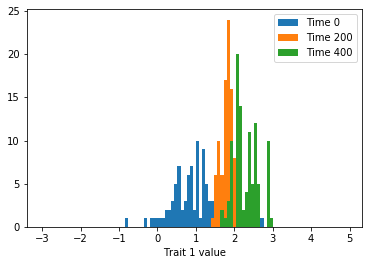

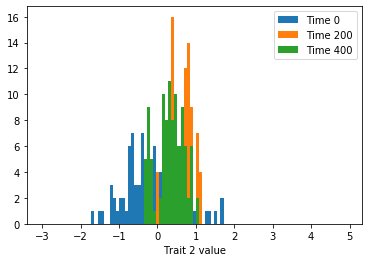

In [113]:
myBins=np.arange(-3,5,0.08)

plt.hist(allPhen[0,0,:],bins=myBins)
plt.hist(allPhen[200,0,:],bins=myBins)
plt.hist(allPhen[400,0,:],bins=myBins)

plt.xlabel('Trait 1 value')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()

plt.hist(allPhen[0,1,:], bins=myBins)
plt.hist(allPhen[200,1,:],bins=myBins)
plt.hist(allPhen[400,1,:],bins=myBins)

plt.xlabel('Trait 2 value')
plt.legend(['Time 0',  'Time 200',  'Time 400'])
plt.show()

(500, 2)
(500,)


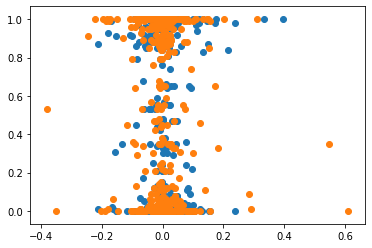

In [114]:
print (np.shape(weights))

lastOne = evolGen[-1,:]   #this is the last time point - complete population
lastOne = np.reshape(lastOne, (nInds, nLoci))
print (np.shape(np.mean(lastOne,0)))
plt.scatter(weights1[:,0], np.mean(lastOne,0), marker='o')
plt.scatter(weights1[:,1], np.mean(lastOne,0), marker='o')
plt.show()

allele frequency at the and es a function of weights

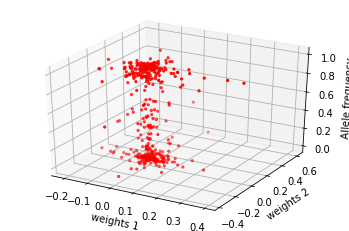

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights1[:,0], weights1[:,1], np.mean(lastOne,0), c='r', marker='.')

ax.set_xlabel('weights 1')
ax.set_ylabel('weights 2')
ax.set_zlabel('Allele frequency')
plt.show()

same, but in 3D, so we can see that weights of the second trait do not play any role. but what about weights of the first trait?!


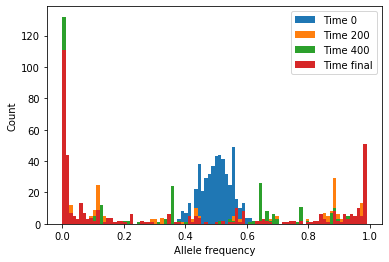

In [116]:
myBins=np.arange(0,1,0.011)


popTime0 = evolGen1[0,:]
popTime0=np.reshape(popTime0, (nInds, nLoci))
plt.hist(np.mean(popTime0,0),bins=myBins)

popTime200 = evolGen1[200,:] 
popTime200=np.reshape(popTime200, (nInds, nLoci))
popTime400 = evolGen1[400,:] 
popTime400=np.reshape(popTime400, (nInds, nLoci))
popTimeEnd = evolGen1[-1,:] 
popTimeEnd=np.reshape(popTimeEnd, (nInds, nLoci))


plt.hist(np.mean(popTime200,0),bins=myBins)

plt.hist(np.mean(popTime400,0),bins=myBins)
plt.hist(np.mean(popTimeEnd,0),bins=myBins)
plt.xlabel('Allele frequency')
plt.ylabel('Count')
plt.legend(['Time 0',  'Time 200',  'Time 400', 'Time final'])
plt.show()



Histogram of allele frequencies, at different times. 


Text(0, 0.5, 'allele count')

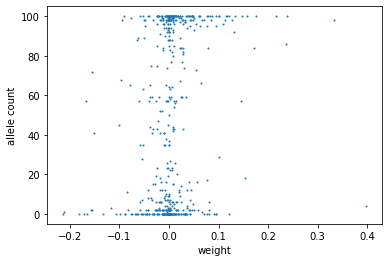

In [128]:
alleleCount = np.sum(popTimeEnd,0)
plt.scatter(weights1[:,0],alleleCount, 1)
plt.xlabel('weight')
plt.ylabel('allele count')

This looks a bit different from Nick's plot
